In [1]:
import os, glob, time, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from skimage.transform import rotate
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# -=-=-=-=-=-=-=-=-=-=-=--==-
# README: Define the csv locations
# -=-=-=-=-=-=-=-=-=-=-=--==-


# ---------- LOAD PROJECT TRAINING DATA ----------

all_labels_np = pd.read_csv("./t_train_project_TEST.csv", header=None)[0].to_numpy(int)
all_images_np = pd.read_csv("./x_train_project_TEST.csv", header=None).to_numpy(np.float32).reshape(-1, 1, 100, 100)
all_images_np = all_images_np / 255.0  # normalize the 0-255 pixel values to be between 0 and 1

# ---------- EASY TEST SET DATA ----------
x_test_easy_np = pd.read_csv("x_test_project_TEST.csv", header=None).to_numpy(dtype=np.float32).reshape(-1, 1, 100, 100)
t_test_easy_np = pd.read_csv("t_test_project_TEST.csv", header=None)[0].to_numpy(dtype=int)
x_test_easy_np = x_test_easy_np / 255.0

# ---------- HARD TEST SET DATA ----------
x_test_hard_np = pd.read_csv("x_test_project_HARD_TEST.csv", header=None).to_numpy(dtype=np.float32).reshape(-1, 1, 100, 100)
t_test_hard_np = pd.read_csv("t_test_project_HARD_TEST.csv", header=None)[0].to_numpy(dtype=int)
x_test_hard_np = x_test_hard_np / 255.0

# -=-=-=-=-=-=-=-=-=-=-=--==-
# Configure hyperparameters here!
# -=-=-=-=-=-=-=-=-=-=-=--==-
BASE_NUM_FILTERS = 70
DROPOUT_RATE = 0.25
LEARNING_RATE = 1e-3  # KEEP FIXED: 1e-4 and smaller LR hurts our validation accuracys
prop = 0  # proportion of the training set to augment (0 => no augmentation)
LABEL_SMOOTHING = 0.1
MONTE_CARLO_PASSES = 50  # number of stochastic forward passes for MC dropout
THRESHOLD_PERCENTILE = 5  # Use n-th percentile of in distribution scores for tuning the distribution score threshold

NUM_MNIST_OOD_SAMPLES = 0  # number of inverted MNIST images for OOD testing
HELD_OUT_CLASS = 9  # which class we want to leave out for OOD testing

NUM_EPOCHS = 40
BATCH_SIZE = 32

EARLY_STOPPING_PATIENCE = 8
# -=-=-=-=-=-=-=-=-=-=-=--==-

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# setting all the random seeds to 0
# tf.random.set_seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)

# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# SECTION 1  – Train-Tune-OOD then Train-Again
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
def train_tune_ood_then_train_again():
    # hold out a particular class-9 for OOD testing (we want to test if the model recognizes
    # that this is a symbol we've never seen before without relying on environmental details
    # such as the paper or average intensity of the training set)
    indices_to_hold_out_class = np.where(all_labels_np == HELD_OUT_CLASS)[0]
    np.random.shuffle(indices_to_hold_out_class)  # shuffle and then take a subset below
    indices_to_hold_out_class_ood = indices_to_hold_out_class[0:]

    training_mask = np.ones_like(all_labels_np, bool)
    training_mask[indices_to_hold_out_class_ood] = False  # exclude the held-out indices

    id_images_placed_ood_np = all_images_np[indices_to_hold_out_class_ood]
    print(f"holding out {len(id_images_placed_ood_np)} samples from class {HELD_OUT_CLASS} for OOD tuning")

    images_train_raw_np, labels_train_raw_np = all_images_np[training_mask], all_labels_np[training_mask]
    print(f"Using {len(images_train_raw_np)} total samples for training/validation.")

    # 80 / 20 validation split (stratified) - keep using sklearn for this
    images_train_base, images_validation_np, labels_train_base, labels_validation_np = train_test_split(images_train_raw_np, labels_train_raw_np, test_size=0.2, stratify=labels_train_raw_np, random_state=0)

    images_train_base_tensor = torch.from_numpy(images_train_base).float()
    labels_train_base_tensor = torch.from_numpy(labels_train_base).long()  # need to use long for cross entropy loss
    images_validation_tensor = torch.from_numpy(images_validation_np).float()
    labels_validation_tensor = torch.from_numpy(labels_validation_np).long()

    # -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # SECTION 2
    # DATA AUGMENTATION (intensity + rotation)
    # -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    def vary_intensity(X_normalized_np, y_np, proportion=0.2, intensity_min=0.5, intensity_max=1.5):
        num_samples_to_impute = int(np.floor(proportion * len(X_normalized_np)))
        if num_samples_to_impute == 0:
            return np.empty((0, 1, 100, 100), dtype=X_normalized_np.dtype), np.empty((0,), dtype=y_np.dtype)
        indices = np.random.choice(len(X_normalized_np), num_samples_to_impute, replace=False)
        X_augmented, y_augmented = [], []
        for i in indices:
            factor = np.random.uniform(intensity_min, intensity_max)
            img_adjusted = np.clip(X_normalized_np[i] * factor, 0.0, 1.0)  # resets to max 1 (normalizes it again)
            X_augmented.append(img_adjusted)
            y_augmented.append(y_np[i])  # add back in the original label
        return np.array(X_augmented), np.array(y_augmented)

    def vary_rotation(X_normalized_np, y_np, proportion=0.2, angle_min=-30, angle_max=30):
        num_samples_to_impute = int(np.floor(proportion * len(X_normalized_np)))
        if num_samples_to_impute == 0:
            return np.empty((0, 1, 100, 100), dtype=X_normalized_np.dtype), np.empty((0,), dtype=y_np.dtype)
        indices = np.random.choice(len(X_normalized_np), num_samples_to_impute, replace=False)
        X_augmented, y_augmented = [], []
        for i in indices:
            img_2d = X_normalized_np[i].squeeze()
            angle = np.random.uniform(angle_min, angle_max)
            rotated_img_2d = rotate(img_2d, angle, resize=False, mode="edge", preserve_range=True)
            X_augmented.append(rotated_img_2d.reshape(1, 100, 100))
            y_augmented.append(y_np[i])  # add back in the original label
        return np.array(X_augmented), np.array(y_augmented)

    def vary_strech(X_normalized, y, proportion=0.2, intensity_max=1.6, intensity_min=0.2):
        num_samples_to_impute = int(np.floor(proportion * len(X_normalized)))
        if num_samples_to_impute == 0:
            return np.empty((0, 1, 100, 100), dtype=X_normalized.dtype), np.empty((0,), dtype=y.dtype)
        indices = np.random.choice(len(X_normalized), num_samples_to_impute, replace=False)
        X_augmented, y_augmented = [], []
        for i in indices:
            factor = np.random.uniform(intensity_min, intensity_max)

            original_image = X_normalized[i]
            original_image = np.transpose(original_image, (1, 2, 0))

            oheight, owidth = original_image.shape[:2]
            oratio = owidth / oheight

            eratio = factor * oratio
            if oratio > eratio:
                # Extend height
                eheight = int(owidth / eratio)
                extended_image = np.ones((eheight, owidth, 1), dtype=original_image.dtype)
                extended_image[:oheight, :, :] = original_image.copy()
            else:
                # Extend width
                ewidth = int(oheight * eratio)
                extended_image = np.ones((oheight, ewidth, 1), dtype=original_image.dtype)
                extended_image[:, :owidth, :] = original_image.copy()

            # Stretch back to 100x100:
            resized = resize(
                extended_image, (100, 100, 1), order=1, mode="reflect", preserve_range=True, anti_aliasing=True
            )
            resized = resized.astype(np.float32)  # keep it in [0, 1]

            X_augmented.append(resized)
            y_augmented.append(y[i])

        X_augmented = np.transpose(np.array(X_augmented), (0, 3, 1, 2))  # (N, 100, 100, 1) → (N, 1, 100, 100)
        return np.array(X_augmented), np.array(y_augmented)

    print(f"augmenting {prop*100}% of the data")
    images_aug_intensity, labels_aug_intensity = vary_intensity(images_train_base, labels_train_base, proportion=prop / 3)
    images_aug_rotation, labels_aug_rotation = vary_rotation(images_train_base, labels_train_base, proportion=prop / 3)
    images_aug_stretch, labels_aug_stretch = vary_strech(images_train_base, labels_train_base, proportion=prop / 3)

    images_train = np.concatenate([images_train_base, images_aug_intensity, images_aug_rotation, images_aug_stretch], axis=0)
    labels_train = np.concatenate([labels_train_base, labels_aug_intensity, labels_aug_rotation, labels_aug_stretch], axis=0)

    print(f"finished augmenting the data… now we have {len(images_train)} training samples")

    images_train_tensor = torch.from_numpy(images_train).float()
    labels_train_tensor = torch.from_numpy(labels_train).long()
    print(f"Training samples: {len(images_train_tensor)}, Validation samples: {len(images_validation_tensor)}")

    # create the tensor datasets and the dataloaders
    train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
    val_dataset = TensorDataset(images_validation_tensor, labels_validation_tensor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    # putting the entire validation set as one batch!
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))

    # -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # SECTION 3  – Model Definition (Residual CNN)
    # -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride=1, projection=False):
            super(ResidualBlock, self).__init__()
            self.projection = projection

            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
            )
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU(inplace=True)  # inplace=True removes the need to create a hard copy in memory
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)

            # the shortcut path for the residual block
            if self.projection:
                self.shortcut_conv = nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False
                )
                self.shortcut_bn = nn.BatchNorm2d(out_channels)

        def forward(self, x):
            shortcut = x

            if self.projection:
                shortcut = self.shortcut_conv(x)
                shortcut = self.shortcut_bn(shortcut)

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)

            out += shortcut
            out = self.relu(out)
            return out

    class ResNet(nn.Module):
        def __init__(self, base_num_filters, dropout_rate):
            super(ResNet, self).__init__()
            self.in_channels = base_num_filters

            # initial layers
            self.conv1 = nn.Conv2d(
                1, base_num_filters, kernel_size=7, stride=2, padding=3, bias=False
            )  # 1 for the grayscale
            self.bn1 = nn.BatchNorm2d(base_num_filters)
            self.relu = nn.ReLU(inplace=True)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            # all the residual blocks
            self.layer1 = self.make_layer(base_num_filters, downsample=False)
            self.layer2 = self.make_layer(base_num_filters * 2, downsample=True)
            self.layer3 = self.make_layer(base_num_filters * 2, downsample=False)
            self.layer4 = self.make_layer(base_num_filters * 4, downsample=True)
            self.layer5 = self.make_layer(base_num_filters * 4, downsample=False)

            # final layers
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.dropout = nn.Dropout(dropout_rate)
            self.fc = nn.Linear(base_num_filters * 4, 10)

        def make_layer(self, out_channels, downsample):
            # makes a residual block
            stride = 2 if downsample else 1
            projection = downsample or (self.in_channels != out_channels)
            block = ResidualBlock(self.in_channels, out_channels, stride=stride, projection=projection)
            self.in_channels = out_channels
            return block

        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.layer5(x)

            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.dropout(x)
            x = self.fc(x)  # RAW LOGITS
            return x

    model = ResNet(BASE_NUM_FILTERS, DROPOUT_RATE).to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # SECTION 4  – Training
    # -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    best_val_accuracy = 0.0
    epochs_without_improvement = 0
    best_model_state = None

    print("Starting training!")
    for epoch in range(NUM_EPOCHS):
        model.train()

        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # moving the data to the device
            optimizer.zero_grad()
            raw_logits = model(inputs)  # Get raw logits
            loss = criterion(raw_logits, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(raw_logits, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples

        # VALIDATION MODE
        model.eval()

        val_running_loss = 0.0
        val_running_corrects = 0
        val_total_samples = 0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                raw_logits_val = model(inputs_val)
                loss_val = criterion(raw_logits_val, labels_val)

                val_running_loss += loss_val.item() * inputs_val.size(0)
                _, preds_val = torch.max(raw_logits_val, 1)
                val_running_corrects += torch.sum(preds_val == labels_val.data)
                val_total_samples += labels_val.size(0)

        val_epoch_loss = val_running_loss / val_total_samples
        val_epoch_acc = val_running_corrects.double() / val_total_samples

        # early stopping check
        if val_epoch_acc > best_val_accuracy:
            best_val_accuracy = val_epoch_acc
            epochs_without_improvement = 0
            best_model_state = model.state_dict()  # Save the best model state
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
                break

    print("done training the first model, obtaining optimal Tau given percentile")

    # use the best model's weights
    model.load_state_dict(best_model_state)

    # -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # SECTION 5
    # OOD Setup and Score Calculation
    # See the Distribution Score of the in distirbution classes' data
    # -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    def energy(logits_tensor):
        # log-sum-exp across the MC-averaged logits
        return -torch.logsumexp(logits_tensor, dim=1)  # shape (N, num_classes)

    def get_average_logits(data_tensor, batch_size=32):
        # Compute mean logits over MONTE_CARLO_PASSES-many stochastic forward passes
        logits_runs_list = []
        temp_dataset = TensorDataset(data_tensor)
        temp_loader = DataLoader(temp_dataset, batch_size=batch_size)

        model.train()
        with torch.no_grad():
            for _ in range(MONTE_CARLO_PASSES):
                batch_logits_list = []
                for (batch,) in temp_loader:
                    batch = batch.to(device)
                    batch_logits = model(batch).detach().cpu()
                    batch_logits_list.append(batch_logits)
                run_logits = torch.cat(batch_logits_list, dim=0)
                logits_runs_list.append(run_logits)

        model.eval()
        all_logits_tensor = torch.stack(logits_runs_list)
        avg_logits_tensor = torch.mean(all_logits_tensor, dim=0)
        return avg_logits_tensor

    validation_logits_tensor = get_average_logits(images_validation_tensor, batch_size=BATCH_SIZE)
    id_scores_tensor = -energy(validation_logits_tensor)  # id scores of validation set for tuning
    id_scores = id_scores_tensor.numpy()
    tau_threshold_value = np.percentile(id_scores, THRESHOLD_PERCENTILE)

    print(f"Found optimal tau value: {tau_threshold_value}")

    # now training the full model using all classes (90/10 split)
    print("Now training the full model using all classes")
    full_images, full_labels = all_images_np, all_labels_np
    full_train, full_val, full_train_lab, full_val_lab = train_test_split(full_images, full_labels, test_size=0.1, stratify=full_labels, random_state=0)
    
    full_training_data_tensor = torch.from_numpy(full_train).float()
    full_training_labels_tensor = torch.from_numpy(full_train_lab).long()
    full_validation_data_tensor = torch.from_numpy(full_val).float()
    full_validation_labels_tensor = torch.from_numpy(full_val_lab).long()
    
    training_dataset_full = TensorDataset(full_training_data_tensor, full_training_labels_tensor)
    validation_dataset_full = TensorDataset(full_validation_data_tensor, full_validation_labels_tensor)
    
    training_loader_full = DataLoader(training_dataset_full, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader_full = DataLoader(validation_dataset_full, batch_size=len(validation_dataset_full))
    
    full_model = ResNet(BASE_NUM_FILTERS, DROPOUT_RATE).to(device)
    loss_function_full = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer_full = optim.Adam(full_model.parameters(), lr=LEARNING_RATE)
    
    best_validation_accuracy_full = 0.0
    epochs_without_improvement_full = 0
    best_model_state_full = None
    
    for _ in range(NUM_EPOCHS):
        full_model.train()
        for training_inputs, training_labels in training_loader_full:
            training_inputs, training_labels = training_inputs.to(device), training_labels.to(device)
            optimizer_full.zero_grad()
            raw_outputs = full_model(training_inputs)
            loss = loss_function_full(raw_outputs, training_labels)
            loss.backward()
            optimizer_full.step()
        full_model.eval()
        with torch.no_grad():
            total_samples, correct_predictions = 0, 0
            for validation_inputs, validation_labels in validation_loader_full:
                validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
                predicted_labels = full_model(validation_inputs).argmax(dim=1)
                correct_predictions += (predicted_labels == validation_labels).sum().item()
                total_samples += validation_labels.size(0)
        current_accuracy = correct_predictions / total_samples
        if current_accuracy > best_validation_accuracy_full:
            best_validation_accuracy_full = current_accuracy
            epochs_without_improvement_full = 0
            best_model_state_full = full_model.state_dict()
        else:
            epochs_without_improvement_full += 1
            if epochs_without_improvement_full >= EARLY_STOPPING_PATIENCE:
                break
    full_model.load_state_dict(best_model_state_full)
    return full_model, tau_threshold_value
    
FINAL_MODEL, TAU_VALUE = train_tune_ood_then_train_again()
print("done training!")

Using device: cuda
holding out 300 samples from class 9 for OOD tuning
Using 2700 total samples for training/validation.
augmenting 20.0% of the data
finished augmenting the data… now we have 2592 training samples
Training samples: 2592, Validation samples: 540
Starting training!
done training the first model, obtaining optimal Tau given percentile
Found optimal tau value: 3.4404170989990233
Now training the full model using all classes
done training!


Easy test set accuracy: 0.9890


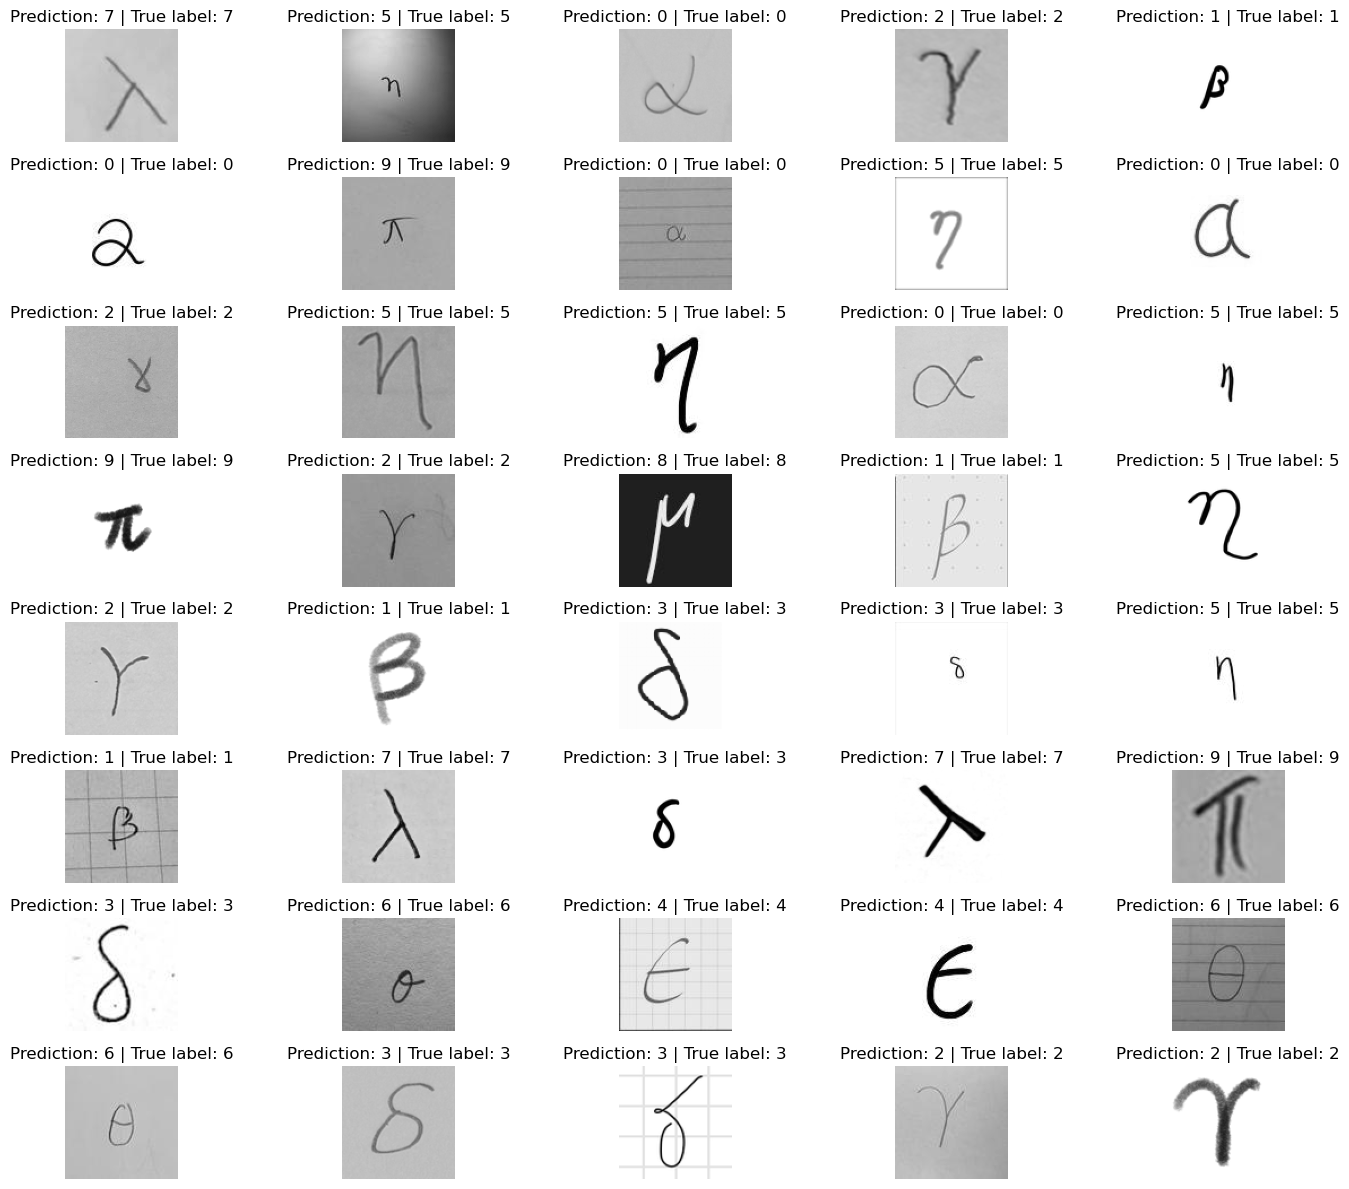

Hard test set accuracy: 0.7063


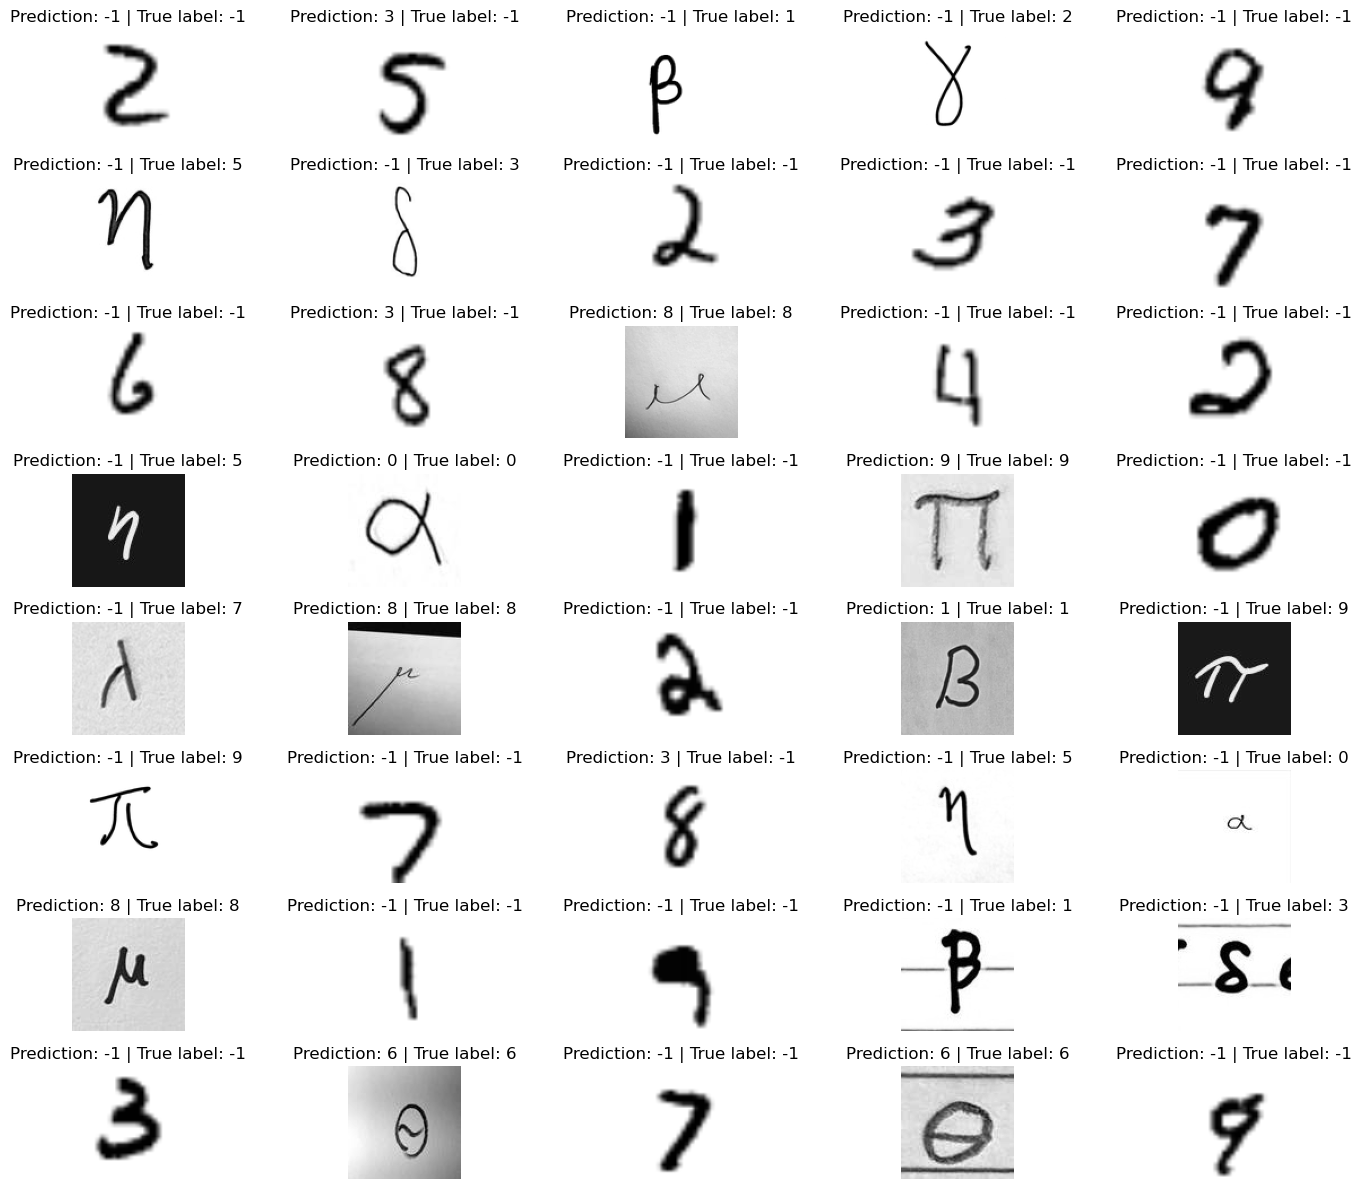

In [2]:
# ---------- ESAY TEST SET ----------
def test(data_np, labels_np):
    data_tensor = torch.from_numpy(data_np.astype(np.float32)).float()
    labels_np = labels_np.astype(int)
    dataset = TensorDataset(data_tensor)
    loader = DataLoader(dataset, batch_size=32)
    preds = []
    FINAL_MODEL.eval()
    with torch.no_grad():
        for (b,) in loader:
            b = b.to(device)
            logits = FINAL_MODEL(b)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
    preds = np.array(preds)
    acc = (preds == labels_np).mean()
    return acc, preds


acc_easy, preds_easy = test(x_test_easy_np, t_test_easy_np)
print(f"Easy test set accuracy: {acc_easy:.4f}")

indices = random.sample(range(len(x_test_easy_np)), 40)
fig, axs = plt.subplots(8, 5, figsize=(15, 12))

for ax, idx in zip(axs.flatten(), indices):
    ax.imshow(x_test_easy_np[idx][0], cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"Prediction: {preds_easy[idx]} | True label: {t_test_easy_np[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# ---------- HARD TEST SET ----------
def energy(logits_tensor):
    return -torch.logsumexp(logits_tensor, dim=1)


def mc_logits(data_tensor, batch_size=32):
    dataset = TensorDataset(data_tensor)
    loader = DataLoader(dataset, batch_size=batch_size)
    runs = []
    FINAL_MODEL.train()
    with torch.no_grad():
        for _ in range(MONTE_CARLO_PASSES):
            outs = []
            for (b,) in loader:
                b = b.to(device)
                outs.append(FINAL_MODEL(b).detach().cpu())
            runs.append(torch.cat(outs, dim=0))
    FINAL_MODEL.eval()
    return torch.mean(torch.stack(runs), dim=0)


def test_hard(data_np, labels_np):
    data_tensor = torch.from_numpy(data_np.astype(np.float32)).float()
    labels_np = labels_np.astype(int)
    logits_avg = mc_logits(data_tensor)
    scores = -energy(logits_avg).numpy()
    raw_predictions = torch.argmax(logits_avg, dim=1).cpu().numpy()

    predictions_list = []

    for s, p in zip(scores, raw_predictions):
        if s < TAU_VALUE:
            predictions_list.append(-1)
        else:
            predictions_list.append(int(p))

    final_predictions = np.array(predictions_list)

    acc = (final_predictions == labels_np).mean()
    return acc, final_predictions


acc_hard, preds_hard = test_hard(x_test_hard_np, t_test_hard_np)
print(f"Hard test set accuracy: {acc_hard:.4f}")

indices = random.sample(range(len(x_test_hard_np)), 40)
fig, axs = plt.subplots(8, 5, figsize=(15, 12))

for ax, idx in zip(axs.flatten(), indices):
    img = x_test_hard_np[idx][0]
    ax.imshow(img, cmap="gray", vmin=img.min(), vmax=img.max())
    ax.set_title(f"Prediction: {preds_hard[idx]} | True label: {t_test_hard_np[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()